# Neural Network Basics (Part 1)
> Under the hood of a basic Deep Learning Image Classifier

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

In [3]:
from fastai.vision.all import *
from fastai.data.external import *
from PIL import Image
import math
torch.manual_seed(100)

# Intro

Today we will be working with a subset of the MNIST dataset. The goal is going to be to take an image of handwritten digits and automatically predict whether it is a 3 or a 7.  We will be building a Neural Network to do this.

If you get through this and want more detail, I highly recommend checking out Deep Learning for Coders with fastai & Pytorch by Jeremy Howard and Sylvain Gugger. All of the material in this guide and more is covered in much greater detail in that book.  They have some awesome courses on their fast.ai website as well.

https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527

# Load the Data

Naturally, the first step is to get and load the data.  We'll look at it a bit along tohe way to make sure it was loaded properly and we understand it.  We will be using fastai's built in dataset feature rather than sourcing it ourself.

In [4]:
# This command downloads the MNIST_TINY dataset and returns the path where it was downloaded
path = untar_data(URLs.MNIST_TINY)

# This takes that path from above, and get the path for the threes and the sevens
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Let's take a look at an image.  The first thing I reccomend doing for any dataset is to view something to verify you loaded it right. The second thing is to look at the size of it.  This is not just for memory concerns, but you want to generally know some basics about whatever you are working with. 

In [5]:
# Let's view what one of the images looks like
im3 = Image.open(threes[1])
im3

In [6]:
# Let's see what shape the underlying matrix is that represents the picture
tensor(im3).shape

torch.Size([28, 28])

What I am going to do below is put the tensor into a dataframe, and color the pixels based on the value in each place.  We can clearly see that this is a 3 just from the values in the tensor.  This should give a good idea for the data we are working with and how an image can be worked with.

In [7]:
pd.DataFrame(tensor(im3)).loc[3:24,6:20].style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,77,181,254,255,95,88,0,0,0,0,0,0
5,0,3,97,242,253,253,253,253,251,117,15,0,0,0,0
6,0,20,198,253,253,253,253,253,253,253,239,59,0,0,0
7,0,0,108,248,253,244,220,231,253,253,253,138,0,0,0
8,0,0,0,110,129,176,0,83,253,253,253,194,24,0,0
9,0,0,0,0,0,26,0,83,253,253,253,253,48,0,0
10,0,0,0,0,0,0,0,83,253,253,253,189,22,0,0
11,0,0,0,0,0,0,0,83,253,253,253,138,0,0,0
12,0,0,0,0,0,0,0,183,253,253,253,138,0,0,0


# Defining our Linear Equation

We are looking to do xw + b = y.   It seems that a Neural network should use some super fancy equation in it's layers, but that's all it is. Basically the same equation everyone learns that defines a line (mx+b)

### Setup

We will need a wieght matrix with 1 weight per pixel, meaning this will be a 784 row by 1 column matrix.  In order to multiply this by our 784 pixels we need to frormat that in 1 row x 784 column matrix.  Then we can do matrix multiplication.  We are also going to add b, so let's initialize that as well.  Since we haven't solved the problem yet, we don't know what good values for w and b are so we will make them random to start with.

>Note: When we checked the shape above, we saw our images were 28 x 28 pixels, which is 784 total pixels.


In [8]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

w = init_params((28*28,1))
b = init_params(1)

In [12]:
max(w)

tensor([2.8108], grad_fn=<SelectBackward>)

Now we just need x and y.  A 784x1 matrix times a 1x784 matrix.  We want all values to be between 0 and 1, so we divide by the max pixel value (255)

In [8]:
# open each image and convert them to a tensor
threes_t = [tensor(Image.open(i)) for i in threes]
sevens_t = [tensor(Image.open(i)) for i in sevens]

# Get my list of tensors and "stack" them.  Also dividing by 255 so all values are between 0 and 1
threes_s = torch.stack(threes_t).float()/255
sevens_s = torch.stack(sevens_t).float()/255

#Verify max and min pixel values
torch.min(threes_s), torch.max(threes_s), torch.min(sevens_s), torch.max(sevens_s)

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

Let's do a simple average of all our threes together and see what we get.  It's a nice sanity check to see that we did things ok.  We can see that after averaging, we pretty much get a three!

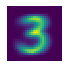

In [9]:
show_image(threes_s.mean(0))

Perfect, lets finish definining our x.  We want x to have both threes and sevens, but right now they are seperate.  We will use torch.cat to combine them, and .view to change the format of the matrix to the right format.  Y is being defined as a long matrix with 1 row per image (prediction) and 1 column.

In [10]:
# combine our threes and sevens into 1 matrix.  Convert Rank 3 matrix to rank 2.
x = torch.cat([threes_s, sevens_s]).view(-1, 28*28)

# Set my y, or dependent variable matrix.  A three will be 1, and seven will be 0.  So we will be prediction 0 or 1.
y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

# Combine by xs and ys into 1 dataset for convenience.
dset = list(zip(x,y))
x_0,y_0 = dset[0]
x_0.shape,y_0

(torch.Size([784]), tensor([1]))

Perfect.  We have exactly what we need and defined above.  A 784 x 1 matrix times a 1 x 784 matrix + a constanct = our prediction.  Let's take a look to verify things are the right shape, and if we actually multiply these things together we get 1 prediction per image.

In [10]:
w.shape,x_0.shape,b.shape,y_0.shape

(torch.Size([784, 1]), torch.Size([784]), torch.Size([1]), torch.Size([1]))

In [11]:
print((x@w+b).shape)
(x@w+b)[1:10]

torch.Size([709, 1])


tensor([[ 3.3164],
        [ 5.2035],
        [-3.7491],
        [ 1.2665],
        [ 2.2916],
        [ 1.3741],
        [-7.6092],
        [ 1.3464],
        [ 2.7644]], grad_fn=<SliceBackward>)

Great, we have the right number of predictions.  Obviosly the predictions are no good at predictions 0 or 1.  After all, our weights and biases are all random.  Let's do something about that.

We will need to do all this on our validation set as well, so let's do that here.

In [12]:
#collapse-hide
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

# Loss Function

We need to improve our weights and biases (w and b) and we do that using gradient descent.  I have a few posts on gradient descent, feel free to check those out if you want details on how it works.  Here we will use the built-in pytorch functionality.

The first thing we need to use gradient descent is we need a loss function.  Let's use something simple, how far off we were.  If the correct answer was 1, and we predicted a 0.5 that would be a loss of 0.5.

The one addition is that we will add something called a sigmoid.  All a sigmoid is doing is ensuring that all of our predictions land between 0 and 1.  We never want to predict anything outside of these ranges as those are our 2 categories.

In [13]:
def mnist_loss(predictions, targets):
    
    # make all prediction between 0 and 1
    predictions = predictions.sigmoid()
    
    # Difference between predictions and target
    return torch.where(targets==1, 1-predictions, predictions).mean()

# Gradient Descent

### Background and Setup
+ predict
+ calculate loss
+ calculate gradient
+ subtract from weights and bias

Ok, now we have a function we need to optimize and a loss function to tell us our error.  We are ready for gradient descent.  Let's create a function to change our weights. 

>Note: If you want more of a background on what is going on here, please take a look at my series on Gradient Descent where I dive deeper on this.  We will be calculating a gradient - which are equivilant to the "Path Value"

In [14]:
# Here is the function to minimize
def linear1(xb): return xb@weights + bias

# Here is how we will initialize paramaters.  This is just giving me random numbers.
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

First, we will make sure our datasets are in a DataLoader.  This is convenience class that helps manage our data and get batches..

In [15]:
dl = DataLoader(dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256)

We are now going to get the first batch out.  We'll use a batch size of 256, but feel free to change that based on your memory.  You can see that we can just simply call first dl, and it creates our shuffled batch for us.

In [16]:
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Let's Initialize our paramaters we will need.  

In [17]:
weights = init_params((28*28,1))
bias = init_params(1)

### Calculate the Gradient

We now have our batch of x and y, and we have our weights and biases.  The next step is to make a prediction.  Since our batch size is 256, we see 256x1 tensor.

In [18]:
preds = linear1(xb)
preds.shape, preds[:5]

(torch.Size([256, 1]), tensor([[-17.7688],
         [ -3.9593],
         [ -4.0014],
         [  1.4874],
         [  0.5148]], grad_fn=<SliceBackward>))

Now we calculate our loss to see how we did.  Probably not well considering all our weights at this point are random.

In [19]:
loss = mnist_loss(preds, yb)
loss

tensor(0.5678, grad_fn=<MeanBackward0>)

Let's calculate our Gradients

In [20]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0011), tensor([-0.0071]))

Since we are going to want to calculate gradients every since step, let's create a function that we can call that does these three steps above.  Let's put all that in a function.  From here on out, we will use this function.

>Note:  It's always a good idea to periodically reviewing and trying to simplify re-usable code.  I reccomend doing following the above approach, make something that works - then simplify.  It often wastes a lot of time trying to write things in the most perfect way from the start.

In [21]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [22]:
calc_grad(xb, yb, linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0022), tensor([-0.0142]))

In [23]:
weights.grad.zero_()
bias.grad.zero_();

### Training the Model

Now we are ready to create a function that trains for 1 epoch.

>Note: Epoch is just a fancy way of saying 1 pass through all our data.

In [24]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

Naturally, we want to be able to measure accuracy.  It's hard for us to gauge how well the model is doing from our loss function.  We will create an accuracy metric to look at accuracy for that batch.

> Note: A loss function is designed to be good for gradient descent.  A Metric is designed to be good for human understanding.  This is why they are different sometimes.

In [25]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [26]:
batch_accuracy(linear1(xb), yb)

tensor(0.4180)

Looking at accuracy of our batch is great, but we also want to look at our accuracy for the validation set.  This is our way to do that using the accuracy funcion we just defined.

In [27]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [28]:
validate_epoch(linear1)

0.4138

Awesome!  Let's throw this all in a loop and see what we get.

In [29]:
params = weights,bias
lr = 1.

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.5249 0.6097 0.7038 0.7628 0.8165 0.8439 0.8685 0.8839 0.8922 0.8984 0.9071 0.9097 0.9136 0.9162 0.9176 0.9202 0.9215 0.9267 0.9311 0.9319 

### Linear Recap

Lots of stuff, but let's recap really what we did:

+ Make a prediction
+ Measure how we did
+ Change our weights so we do slightly better next time
+ Print out accuracy metrics along the way so we can see how we are doing

This is a huge start, but what we have is a linear model.  Now we need to add non-linearities so that we can have a true Neural Network.

# ReLu

### What is it?

First, a ReLu is our non-linearity in a neural network.  A neural network is just alternating linear and nonlinear layers.  We defined the Linear layer above, here we will talk about the non-linear ones.  So what exactly does the non-linear layer do?  It's actually much simpler than people like to believe, it's just a max.

For example, I am going to apply a ReLu to a matrix.  

$\begin{bmatrix}-1&1\\-1&-1\\0&0\\0&1\\1&-1\\1&0\\-1&0\\-1&-1\\1&1\end{bmatrix}$
$=>$
$\begin{bmatrix}0&1\\0&0\\0&0\\0&1\\1&0\\1&0\\0&0\\0&0\\1&1\end{bmatrix}$

As you will see I just took max(x,0).  Another way of saying that is I replaced any negative values with 0.  That's all a ReLu is.

### In a Neural Network

These ReLus go between our linear layers.  Here's what a simple Neural Net looks like.

In [30]:
# initialize random weights.  
# The number 30 here can be adjusted for more a less model complexity.  Future posts will talk more about what that is.

w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [31]:
# Here's a simple Neural Network.  
# This can have more layers by duplicating the patten seen below, this is just the simplest model.

def simple_net(xb): 
    res = xb@w1 + b1 #Linear
    res = res.max(tensor(0.0)) #ReLu
    res = res@w2 + b2 #Linear
    return res

# Train the Full Neural Network

So we have our new model with new weights.  It's more than just the linear model, so how do we use gradient descent?  We now have 4 weights (w1,w2,b1,b2).

Turns our it's exactly what we already did.  Let's add the new paramaters to our paramsm, and change out the linear model with the simple_net we just defined.  We end up with a pretty decent accuracy!

In [11]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [33]:
params = w1,b1,w2,b2
lr = 1

for i in range(20):
    train_epoch(simple_net, lr, params)
    print(validate_epoch(simple_net), end=' ')

0.6711 0.8028 0.8865 0.9198 0.9245 0.9225 0.9291 0.9223 0.9402 0.9433 0.9343 0.9433 0.9392 0.9392 0.9463 0.9431 0.9476 0.9489 0.9457 0.9528 

# Recap of Tensor Shapes

Understanding the shapes of these tensors and how the network works is crucial.  Here's the network we built.  You can see how each layer can fit into the next layer.

In [15]:
x.shape,w1.shape,b1.shape,w2.shape,b2.shape

(torch.Size([709, 784]),
 torch.Size([784, 30]),
 torch.Size([30]),
 torch.Size([30, 1]),
 torch.Size([1]))

![](my_icons/simple_net.png)

# What More?

This is a Neural Network.  Now we can do tweaks to enhance performance.  I will talk about those in future posts, but here's a few concepts.

+ Instead of a Linear Layer, A ReLu, then a linear layer - Can we add more layers to have a deeper net?
+ What if we average some of the pixels in our image together before dong matrix multiplication (ie a convolutions)?
+ Can we randomly ignore pixels to prevent overfitting (ie dropout)?

There are many 'advanced' variations of Neural Networks, but the concepts are typically along the lines of above.  If you boil them down to what they are really doing - they are pretty simple concepts.